In [3]:
from threading import Lock
import warnings
import matplotlib.pyplot as plt
import pyximport
from tqdm import tnrange, tqdm_notebook
from concurrent.futures import ThreadPoolExecutor,as_completed

warnings.filterwarnings('ignore')

import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), os.pardir))
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

pyximport.install(setup_args={"include_dirs": np.get_include()})
import XXZZham as XXZZham
from XXZZham import add_high_energies, rotate_to_00_base
import random
import adiabatic_sim as asim
import time

import multiprocessing
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(multiprocessing.cpu_count())))
import os
import LH_tools as LHT

%precision %.15f
PRECISION  = 2 ** -40

from IPython.display import display
from functools import reduce
import FD_tools as FDT

In [39]:
class LZ_Ham:
    def __init__(self, delta, omega, A, epsilon0):
        self.delta = delta
        self.omega = omega
        self.A = A
        self.epsilon0 = epsilon0
    
    def getHt(self, t):
        try:
            Ht = 1/2 * np.array([sigmaz()* s for s in (self.A *np.sin(self.omega * t) + self.epsilon0)])
            Ht +=1/2 * self.delta*sigmax()
        except Exception as e:
            print("self.A,self.omega,t,self.epsilon0:" , self.A,self.omega,t,self.epsilon0)
            print(e)
        return Ht
    
    def getEV(self, t):
        return [Ht.eigenenergies() for Ht in self.getHt(t)]
    
    def getProp(self, tlist):
        Hts = self.getHt(tlist)
        dt = tlist[1] - tlist[0]
        Uts = [(-1j * Ht * dt).expm() for Ht in Hts]
        U  = reduce((lambda x, y: x * y), Uts)
        return U


In [182]:
def _simulate_plz_for_LZ(delta, omega, A=1, epsilon0=0.1):
    H = LZ_Ham(delta=delta, omega=omega, A=A, epsilon0=epsilon0)
    tlist = np.linspace(-1 / 2, 1/2, 1000) * np.pi/omega
    prop = H.getProp(tlist)
    Plz = abs(prop[0][0][1])**2
    return Plz

def _simulate_p2_for_LZ(delta, omega, A=1, epsilon0=0.1):
    H = LZ_Ham(delta=delta, omega=omega, A=A, epsilon0=epsilon0)
    tlist = np.linspace(-1 / 2, 1.5, 300) * np.pi/omega
    prop = H.getProp(tlist)
    P2stay = abs(prop[0][0][0])**2
    return P2stay


def _simulate_p2_for_LZ_with_z2_phase(delta, omega, A=1, epsilon0=0.1, steps=300):
    
    H = LZ_Ham(delta=delta, omega=omega, A=A, epsilon0=epsilon0)
    tlist = np.linspace(-1 / 2, 1.5, steps) * np.pi/omega
    prop = H.getProp(tlist)
    P2stay = abs(prop[0][0][0])**2
    
    #Hamiltonians relevant to z2 phase are those that appears between the crossings, 
    # i.e. at times in [0, 1] *pi/omega which is half of the time of the evolution
    z2_tlist = np.linspace(0, 1, steps / 2) * np.pi / omega
    z2_evs = H.getEV(z2_tlist)
    dt = z2_tlist[1] - z2_tlist[0]
    z2_phase = 1/2*(dt * ( sum(z2_evs)[1] - sum(z2_evs)[0]))
    return P2stay, z2_phase

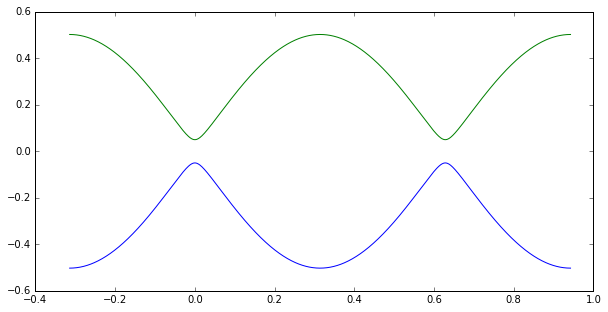

[]


Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = False
Qobj data =
[[ 0.99806195+0.00038008j  0.00000000-0.06222703j]
 [ 0.00000000-0.06222703j  0.99806195-0.00038008j]]

In [242]:
H = LZ_Ham(delta=0.1, omega=5, A=1, epsilon0=0.0)
tlist = np.linspace(-1 / 2, 1.5, 1000) * np.pi/5
Htev = H.getEV(tlist)
plt.figure(figsize=(10, 5))
plt.plot(tlist, Htev)
plt.show()
from scipy.signal import argrelmin, argrelmax
print(tlist[argrelmin(np.array(Htev)[0:, 0])])
prop = H.getProp(tlist)
prop

In [260]:
_simulate_p2_for_LZ(delta=0.1, omega=10, A=1, epsilon0=0.0)

0.999976936706292

In [265]:
from concurrent.futures import ThreadPoolExecutor,as_completed

executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

P2stays = []
for omega in np.linspace(0.1,30,300):
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)


KeyboardInterrupt: 

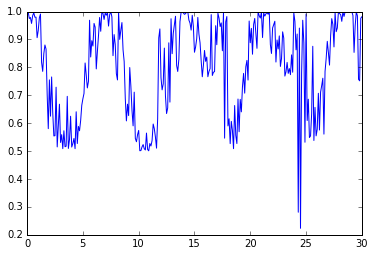

In [270]:
plt.plot(np.linspace(0.1,30,300),A)
plt.show()

In [274]:

executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in np.linspace(0.1,30,300):
    tasks.append(
        executor.submit(
            _simulate_plz_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)


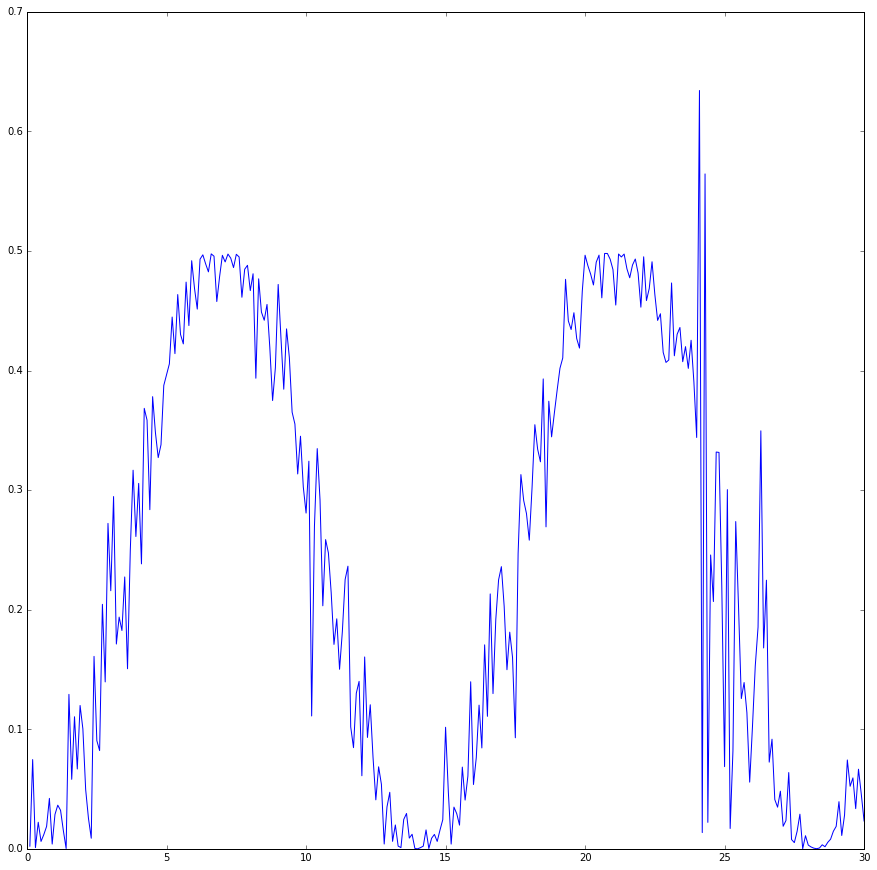

In [275]:
plt.plot(np.linspace(0.1,30,300),A)
plt.show()

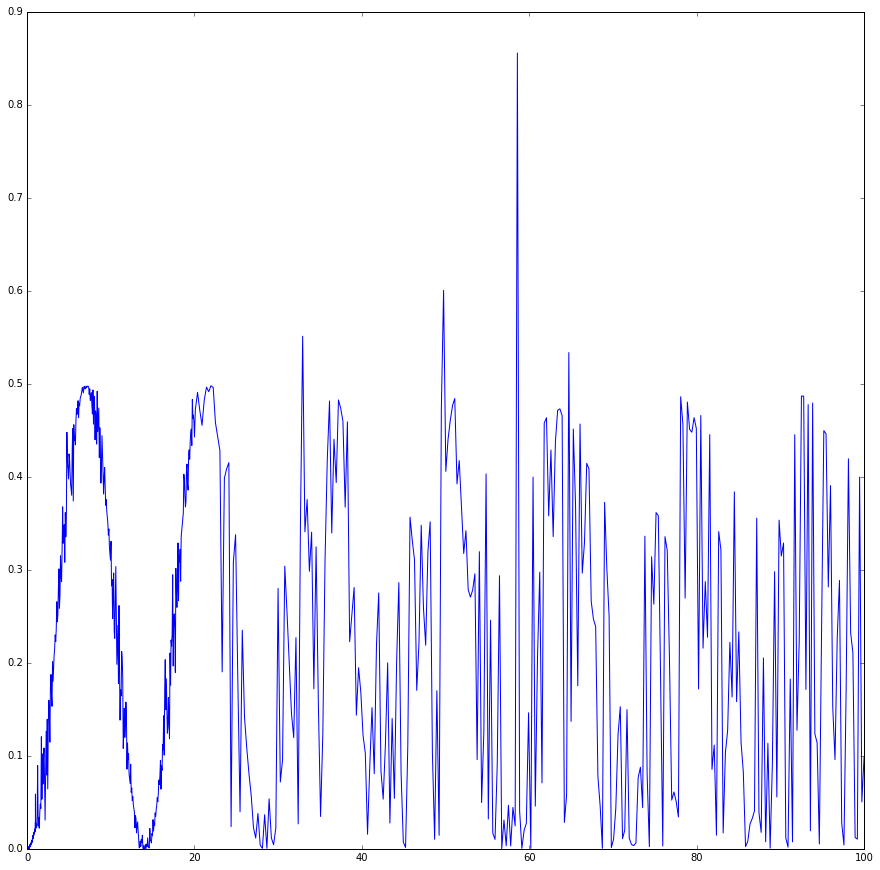

In [4]:
omegas = np.concatenate([np.linspace(0.0001,1,300) , np.linspace(1.01,20,300),np.linspace(20.1,100,300)])


executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_plz_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)
plt.plot(omegas,A)
plt.show()

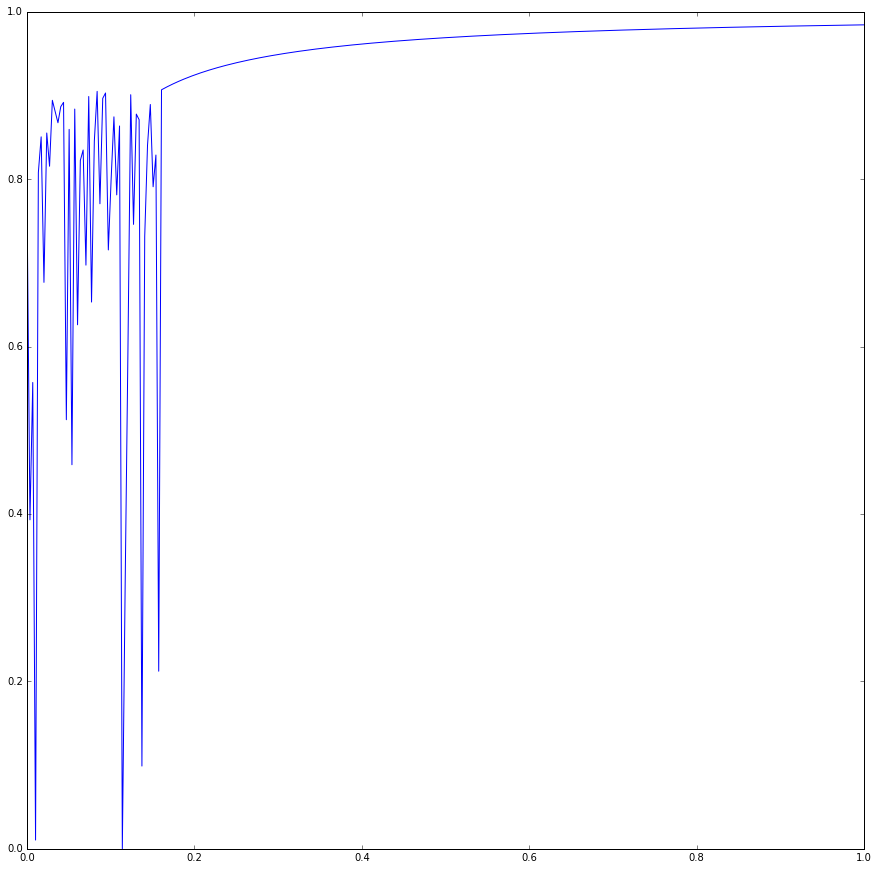

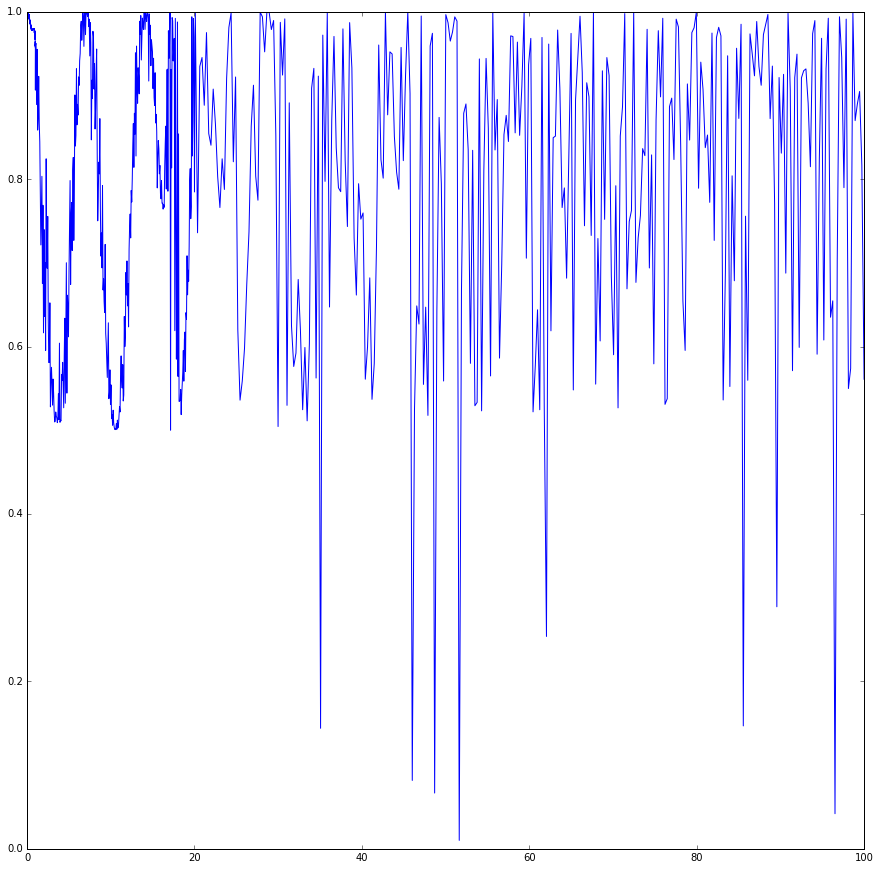

In [4]:
omegas = np.concatenate([np.linspace(0.0001,1,300) , np.linspace(1.01,20,300),np.linspace(20.1,100,300)])


executor = ThreadPoolExecutor(48)
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
A = np.array(results)
plt.plot(omegas,A)
plt.show()

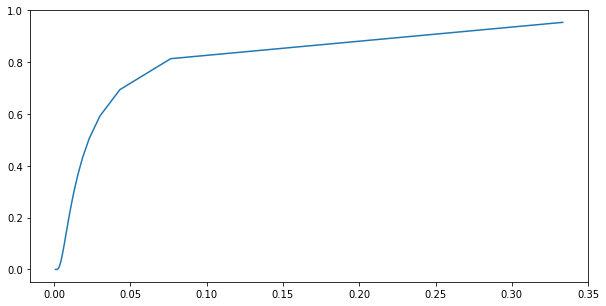

In [81]:
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,lzs)
plt.show()

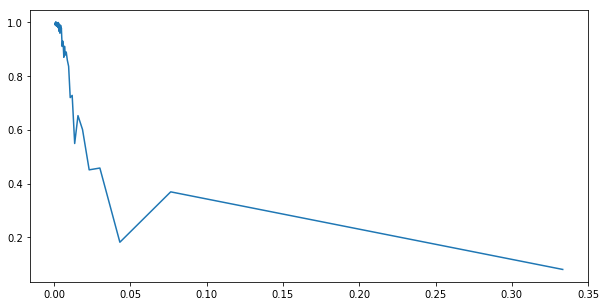

In [79]:
one_over_omega = np.linspace(3,1000,100)
omegas = 1/one_over_omega

executor = ThreadPoolExecutor()
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_plz_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
plt.figure(figsize=(10,5))
plt.plot(omegas,results_ar)
plt.show()

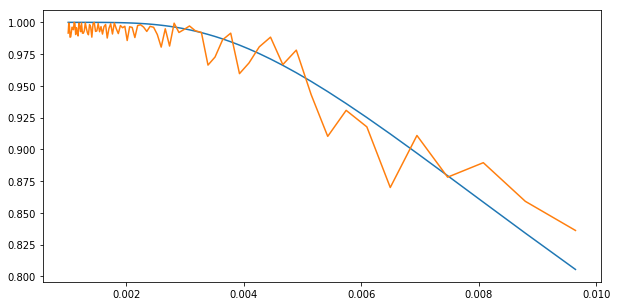

In [88]:
plt.figure(figsize=(10,5))

plt.plot(omegas[10:-1],1-lzs[10:-1])
plt.plot(omegas[10:-1],results_ar[10:-1])
plt.show()

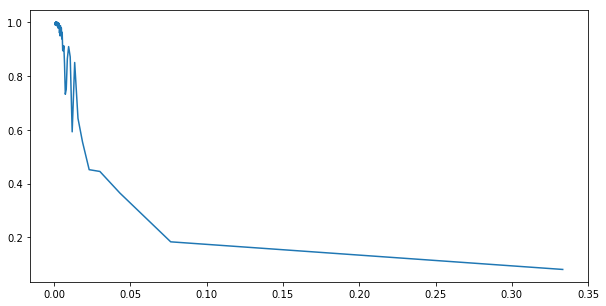

In [90]:
one_over_omega = np.linspace(3,1000,100)
omegas = 1/one_over_omega

executor = ThreadPoolExecutor()
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_plz_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
plt.figure(figsize=(10,5))
plt.plot(omegas,results_ar)
plt.show()

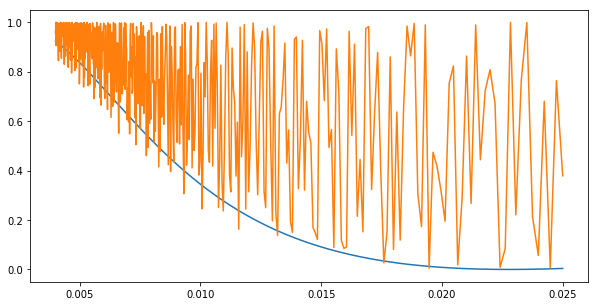

In [99]:
# one_over_omega = np.linspace(40,250,500)
# omegas = 1/one_over_omega
omegas = np.linspace(0.006,0.008,100)
executor = ThreadPoolExecutor()
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
plt.figure(figsize=(10,5))


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs))
##########


plt.plot(omegas,results_ar)
plt.show()
pass

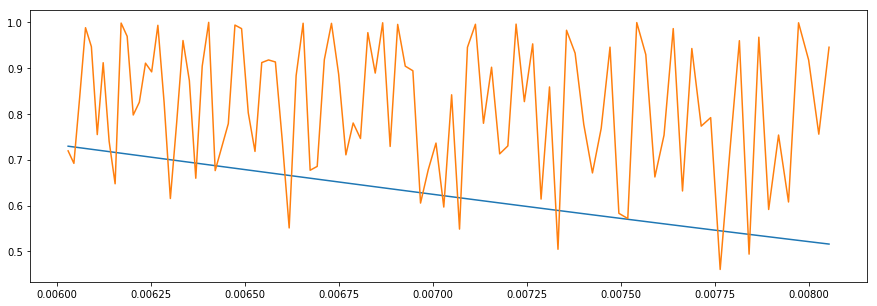

In [114]:
plt.figure(figsize=(15,5))
start = 200
end = -200
plt.plot(omegas[start:end],1-4*lzs[start:end]*(1-lzs[start:end]))
##########


plt.plot(omegas[start:end],results_ar[start:end])


plt.show()


pass

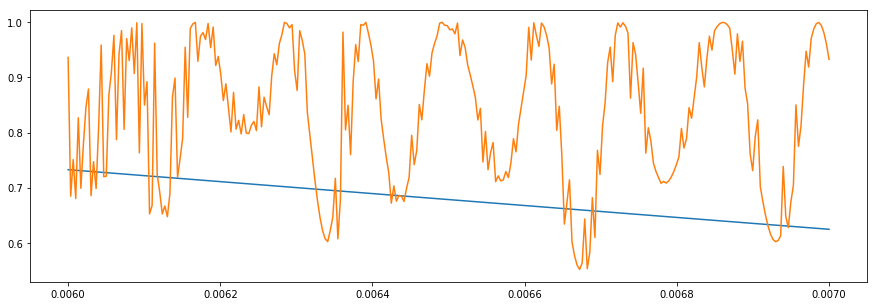

In [117]:
omegas = np.linspace(0.006,0.007,300)
executor = ThreadPoolExecutor()
tasks = []
plt.figure(figsize=(15,15))

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
plt.figure(figsize=(15,5))


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs))
##########


plt.plot(omegas,results_ar)
plt.show()
pass

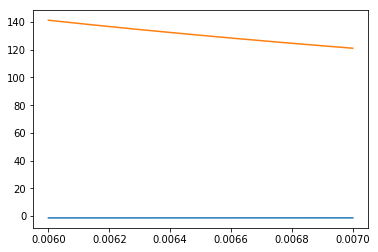

In [142]:
# compare to theoretical oscilations
# check lzphase 
import scipy.special
stockes_phase = np.pi/4 + ds * (np.log(ds) -1) + np.angle(scipy.special.gamma(1-1j*ds))
lzphase = -np.pi/2  + stockes_phase

z2_phase_est = -epsilon0/omegas *np.arccos(epsilon0/A) + np.sqrt((A**2-epsilon0**2))/omegas
plt.plot(omegas,lzphase)
plt.plot(omegas,z2_phase_est)
plt.show()

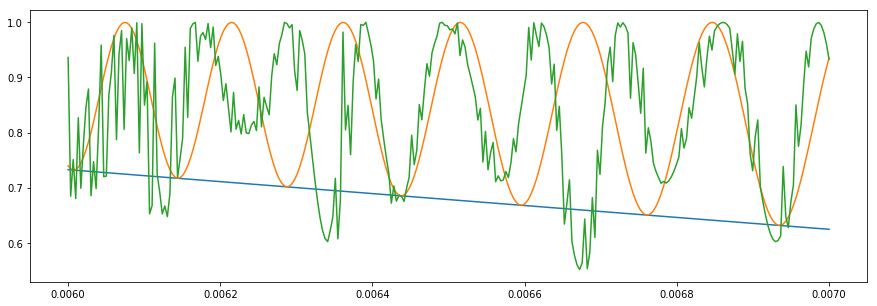

In [145]:
plt.figure(figsize=(15,5))


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs))
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phase_est)**2)
##########


plt.plot(omegas,results_ar)
plt.show()
pass

In [146]:
Evs=  H.getEV(tlist)

In [149]:
sum(Evs)[1]-sum(Evs)[0]

196.300507032114325

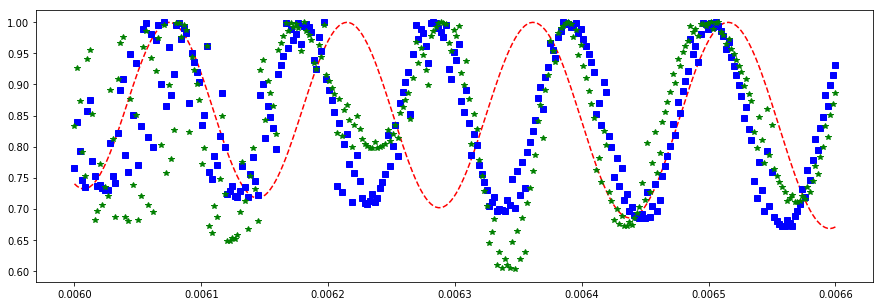

In [183]:
_simulate_p2_for_LZ_with_z2_phase

plt.figure(figsize=(15,5))

omegas = np.linspace(0.006,0.0066,300)
executor = ThreadPoolExecutor()
tasks = []

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ_with_z2_phase, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
P2s = results_ar[0:,0]
z2_phases = results_ar[0:,1]


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
stockes_phase = np.pi/4 + ds * (np.log(ds) -1) + np.angle(scipy.special.gamma(1-1j*ds))
lzphase = -np.pi/2  + stockes_phase

z2_phase_est = -epsilon0/omegas *np.arccos(epsilon0/A) + np.sqrt((A**2-epsilon0**2))/omegas
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phase_est)**2,'r--')
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phases)**2,'bs')

##########


plt.plot(omegas,P2s,'g*')
plt.show()
pass

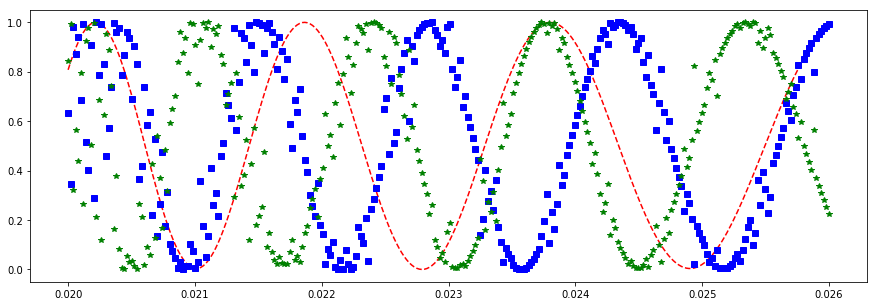

In [186]:
_simulate_p2_for_LZ_with_z2_phase

plt.figure(figsize=(15,5))

omegas = np.linspace(0.02,0.026,300)
executor = ThreadPoolExecutor()
tasks = []

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ_with_z2_phase, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
P2s = results_ar[0:,0]
z2_phases = results_ar[0:,1]


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
stockes_phase = np.pi/4 + ds * (np.log(ds) -1) + np.angle(scipy.special.gamma(1-1j*ds))
lzphase = -np.pi/2  + stockes_phase

z2_phase_est = -epsilon0/omegas *np.arccos(epsilon0/A) + np.sqrt((A**2-epsilon0**2))/omegas
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phase_est)**2,'r--')
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phases)**2,'bs')

##########


plt.plot(omegas,P2s,'g*')
plt.show()
pass

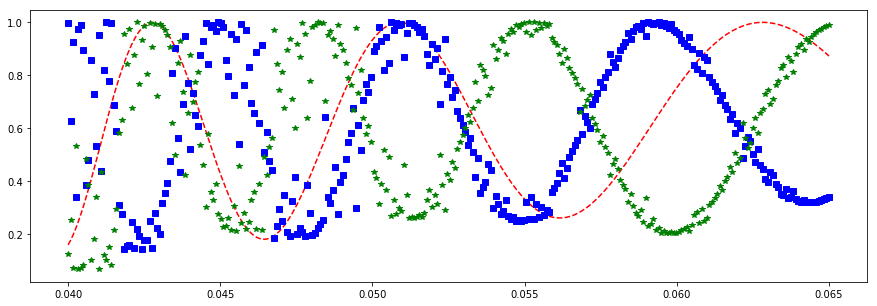

In [196]:
_simulate_p2_for_LZ_with_z2_phase

plt.figure(figsize=(15,5))

omegas = np.linspace(0.04,0.065,300)
executor = ThreadPoolExecutor()
tasks = []

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ_with_z2_phase, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
P2s = results_ar[0:,0]
z2_phases = results_ar[0:,1]


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
stockes_phase = np.pi/4 + ds * (np.log(ds) -1) + np.angle(scipy.special.gamma(1-1j*ds))
lzphase = -np.pi/2  + stockes_phase

z2_phase_est = -epsilon0/omegas *np.arccos(epsilon0/A) + np.sqrt((A**2-epsilon0**2))/omegas
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phase_est)**2,'r--')
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phases)**2,'bs')

##########


plt.plot(omegas,P2s,'g*')
plt.show()
pass

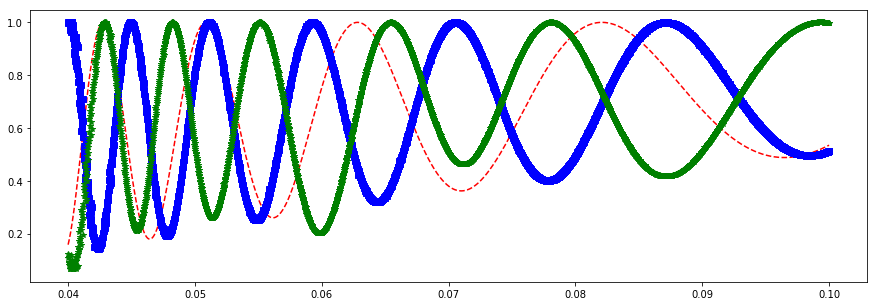

In [200]:
_simulate_p2_for_LZ_with_z2_phase

plt.figure(figsize=(15,5))

omegas = np.linspace(0.04,0.1,3000)
executor = ThreadPoolExecutor()
tasks = []

PLZ = []
for omega in omegas:
    tasks.append(
        executor.submit(
            _simulate_p2_for_LZ_with_z2_phase, 0.1 ,omega
    )
)
results = [simulation.result() for simulation in as_completed(tasks)]
results_ar = np.array(results)
P2s = results_ar[0:,0]
z2_phases = results_ar[0:,1]


##########
epsilon0 = 0.1
A = 1
delta = 0.1
vs = A*omegas *np.sqrt(1-(epsilon0/A)**2)
ds = delta**2 / (4*vs)
lzs = np.exp(-2*np.pi*ds)
stockes_phase = np.pi/4 + ds * (np.log(ds) -1) + np.angle(scipy.special.gamma(1-1j*ds))
lzphase = -np.pi/2  + stockes_phase

z2_phase_est = -epsilon0/omegas *np.arccos(epsilon0/A) + np.sqrt((A**2-epsilon0**2))/omegas
# plt.plot(omegas,vs)
# plt.plot(omegas,ds)
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phase_est)**2,'r--')
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phases)**2,'bs')

##########


plt.plot(omegas,P2s,'g*')
plt.show()
pass

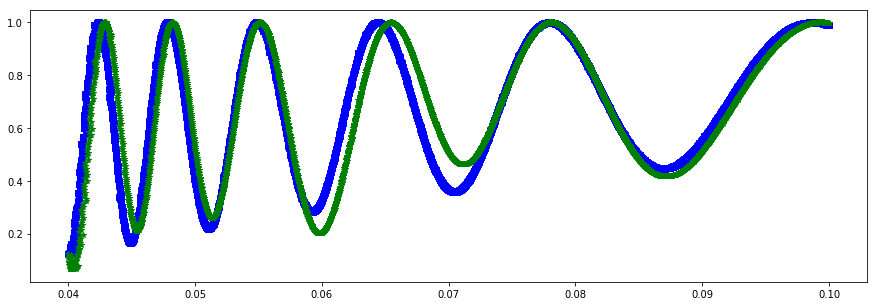

In [241]:
plt.figure(figsize=(15,5))
# +pi/2 to fix?
plt.plot(omegas,1-4*lzs*(1-lzs)*np.sin(lzphase+z2_phases+np.pi/2)**2,'bs')
plt.plot(omegas,P2s,'g*')
plt.show()

In [222]:
1/np.sqrt(2)

0.707106781186547